# SIR Model

The SIR model tracks the ratio of Susceptible($S$), Infected($I$), Recovered($R$) individuals within a population. 

Here we add one more category of individuals: those who are infected, but do not know it (Asymptomatic?).

Transmission rate of infected and diagnosed is lower than infected and undetected. We also allow a fraction of recovered individuals to catch the disease again, meaning that recovering the disease does not bring full immunity.

## Model Parameters

Here are the model parameters, some of which have default values.

* `Ns`: a vector of population sizes per city. The amount of cities is just `C=length(Ns)`.
* `β_und`: a vector for transmission probabilities β of the infected but undetected per city. Transmission probability is how many susceptiple are infected per day by an infected individual. If social distancing is practiced, this number increases.
* `β_det`: an array for transmission probabilities β of the infected and detected per city. If hospitals are full, this number increases.
* `infection_period = 30`: how many days before a person dies or recovers.
* `detection_time = 14`: how many days before an infected person is detected.
* `death_rate = 0.02`: the probability that the individual will die after the infection_period.
* `reinfection_probability = 0.05`: The probabiity that a recovered person can get infected again.
* `migration_rates`: A matrix of migration probability per individual per day from one city to another.
* `Is = [zeros(C-1)..., 1]`: An array for initial number of infected but undetected people per city. This starts as only one infected individual in the last city.

Notice that all `Ns`, `β`, `Is` need to have the same length, as they are numbers for each city. We've tried to add values to the infection parameters similar to the ones you would hear on the news about COVID-19.

The good thing with Agent based models is that you could easily extend the model we implement here to also include age as the agent's property. This makes ABMs flexible and suitable for research of virus spreading.

## Model Development 

We start by defining the `PoorSoul` agent type and the ABM

In [2]:
using Agents, Random, DataFrames, LightGraphs
using Distributions: Poisson, DiscreteNonParametric
using DrWatson: @dict
using Plots

mutable struct PoorSoul <: AbstractAgent
  id::Int
  pos::Int
  days_infected::Int  # number of days since is infected
  status::Symbol  # 1: S, 2: I, 3:R
end

function model_initiation(;Ns, migration_rates, β_und, β_det, infection_period = 30,
  reinfection_probability = 0.05, detection_time = 14, death_rate = 0.02,
  Is=[zeros(Int, length(Ns)-1)..., 1], seed = 0)

  Random.seed!(seed)
  @assert length(Ns) == length(Is) == length(β_und) == length(β_det) == size(migration_rates, 1) "length of Ns, Is, and B, and number of rows/columns in migration_rates should be the same "
  @assert size(migration_rates, 1) == size(migration_rates, 2) "migration_rates rates should be a square matrix"

  C = length(Ns)
  # normalize migration_rates
  migration_rates_sum = sum(migration_rates, dims=2)
  for c in 1:C
    migration_rates[c, :] ./= migration_rates_sum[c]
  end

  properties =
    @dict(Ns, Is, β_und, β_det, β_det, migration_rates, infection_period,
    infection_period, reinfection_probability, detection_time, C, death_rate)
  space = Space(complete_digraph(C))
  model = ABM(PoorSoul, space; properties=properties)

  # Add initial individuals
  for city in 1:C, n in 1:Ns[city]
    ind = add_agent!(city, model, 0, :S) # Susceptible
  end
  # add infected individuals
  for city in 1:C
    inds = get_node_contents(city, model)
    for n in 1:Is[city]
      agent = id2agent(inds[n], model)
      agent.status = :I # Infected
      agent.days_infected = 1
    end
  end
  return model
end

model_initiation (generic function with 1 method)

We will make a function that starts a model with `C` number of cities, and creates the other parameters automatically by attributing some random values to them. You could directly use the above constructor and specify all `Ns`, `β`, etc. but the following is convenient for this example.

All cities are connected with each other, while it is more probable to travel from a city with small population into a city with large population.

In [3]:
using LinearAlgebra: diagind

function create_params(;C, max_travel_rate, infection_period = 30,
    reinfection_probability = 0.05, detection_time = 14, death_rate = 0.02,
    Is=[zeros(Int, C-1)..., 1], seed = 19
  )

  Random.seed!(seed)
  Ns = rand(50:5000, C)
  β_und = rand(0.3:0.02:0.6, C)
  β_det = β_und ./ 10

  Random.seed!(seed)
  migration_rates = zeros(C, C);
  for c in 1:C
    for c2 in 1:C
      migration_rates[c, c2] = (Ns[c] + Ns[c2])/Ns[c]
    end
  end
  maxM = maximum(migration_rates)
  migration_rates = (migration_rates .* max_travel_rate) ./ maxM
  migration_rates[diagind(migration_rates)] .= 1.0

  params = @dict(Ns, β_und, β_det, migration_rates, infection_period,
    reinfection_probability, detection_time, death_rate, Is)

  return params
end

params = create_params(C=8, max_travel_rate=0.01)
model = model_initiation(;params...)

AgentBasedModel with 15994 agents of type PoorSoul
 space: GraphSpace with 8 nodes and 56 edges
 scheduler: fastest
 properties: Dict{Symbol,Any}(:Is => [0, 0, 0, 0, 0, 0, 0, 1],:death_rate => 0.02,:infection_period => 30,:β_und => [0.34, 0.46, 0.42, 0.56, 0.38, 0.54, 0.32, 0.56],:Ns => [560, 1173, 2461, 4937, 341, 933, 3195, 2394],:migration_rates => [0.9781587717872465 0.001955711919639436 … 0.0042375639112787545 0.0033336255110299443; 0.0009425639246973993 0.9874730915674378 … 0.00237571795907573 0.0019400608882836835; … ; 0.0007539574926755328 0.0008770403004012589 … 0.9929395043215865 0.0011222019777799074; 0.0007907291204425011 0.0009548174585708876 … 0.001496068061663216 0.991873745890862],:detection_time => 14,:reinfection_probability => 0.05,:β_det => [0.034, 0.046, 0.041999999999999996, 0.05600000000000001, 0.038, 0.054000000000000006, 0.032, 0.05600000000000001],:C => 8…)

Alright, let's plot the cities as a graph to get an idea how the model "looks like", using the function `plotabm`.

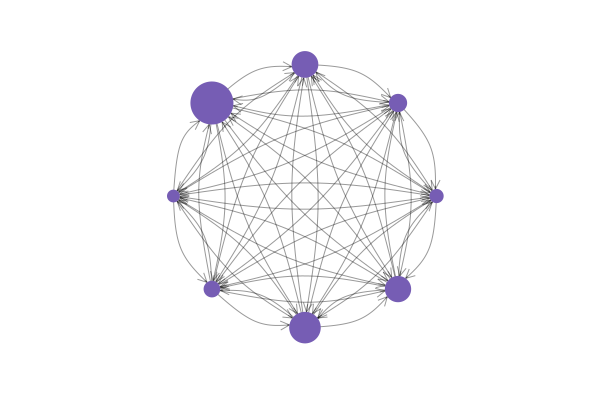

In [7]:
using AgentsPlots

plotargs = (node_size = 0.2, method = :circular, linealpha = 0.4)

plotabm(model; plotargs...)

The node size is proportional to the relative population of each city. In principle we could adjust the edge widths to be proportional with the migration rates, by doing:

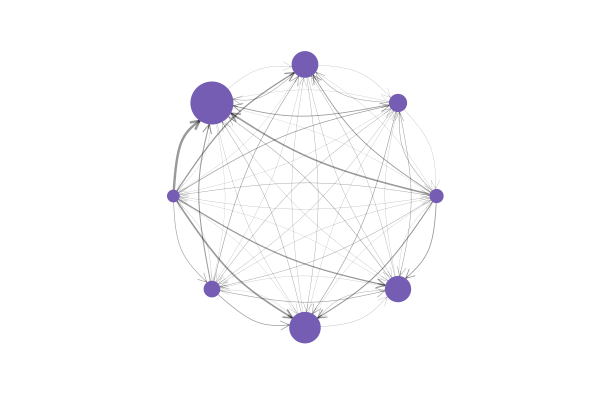

In [8]:
g = model.space.graph
edgewidthsdict = Dict()
for node in 1:nv(g)
  nbs = neighbors(g, node)
  for nb in nbs
    edgewidthsdict[(node, nb)] = params[:migration_rates][node, nb]
  end
end

edgewidthsf(s, d, w) = edgewidthsdict[(s, d)] * 250

plotargs = merge(plotargs, (edgewidth = edgewidthsf,))

plotabm(model; plotargs...)

In the following we will be colloring each node according to how large percentage of the population is infected. So we create a function to give to plotabm as second argument

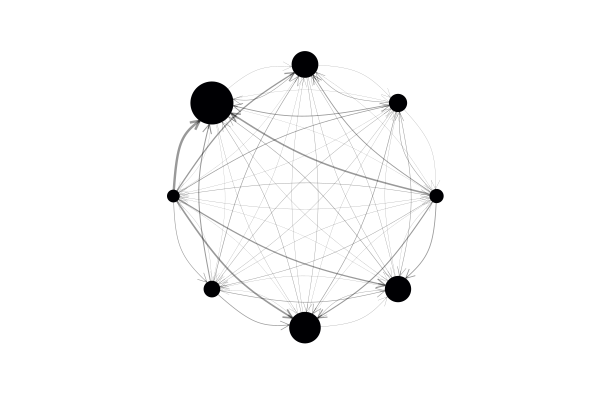

In [10]:
infected_fraction(x) =  cgrad(:inferno)[count(a.status == :I for a in x)/length(x)]
plotabm(model, infected_fraction; plotargs...)

Here this shows all nodes as black, since we haven't run the model yet. Let's change that!

## SIR Evolution

Now we define the functions for modelling the virus spread in time

In [11]:
function agent_step!(agent, model)
  migrate!(agent, model)
  transmit!(agent, model)
  update!(agent, model)
  recover_or_die!(agent, model)
end

function migrate!(agent, model)
  nodeid = agent.pos
  d = DiscreteNonParametric(1:model.properties[:C], model.properties[:migration_rates][nodeid, :])
  m = rand(d)
  if m ≠ nodeid
    move_agent!(agent, m, model)
  end
end

function transmit!(agent, model)
  agent.status == :S && return
  prop = model.properties
  rate = if agent.days_infected < prop[:detection_time]
    prop[:β_und][agent.pos]
  else
    prop[:β_det][agent.pos]
  end

  d = Poisson(rate)
  n = rand(d)
  n == 0 && return

  for contactID in get_node_contents(agent, model)
    contact = id2agent(contactID, model)
    if contact.status == :S || (contact.status == :R && rand() ≤ prop[:reinfection_probability])
      contact.status = :I
      n -= 1
      n == 0 && return
    end
  end
end

update!(agent, model) = agent.status == :I && (agent.days_infected += 1)

function recover_or_die!(agent, model)
  if agent.days_infected ≥ model.properties[:infection_period]
    if rand() ≤ model.properties[:death_rate]
      kill_agent!(agent, model)
    else
      agent.status = :R
      agent.days_infected = 0
    end
  end
end

recover_or_die! (generic function with 1 method)

## Example Animation

In [13]:
model = model_initiation(;params...)

anim = @animate for i ∈ 1:30
  step!(model, agent_step!, 1)
  p1 = plotabm(model, infected_fraction; plotargs...)
  title!(p1, "Day $(i)")
end

gif(anim, "covid_evolution.gif", fps = 5);

model

┌ Info: Saved animation to 
│   fn = /Users/pietromonticone/github/data-science/Julia/covid_evolution.gif
└ @ Plots /Users/pietromonticone/.julia/packages/Plots/NVH6y/src/animation.jl:102


AgentBasedModel with 15994 agents of type PoorSoul
 space: GraphSpace with 8 nodes and 56 edges
 scheduler: fastest
 properties: Dict{Symbol,Any}(:Is => [0, 0, 0, 0, 0, 0, 0, 1],:death_rate => 0.02,:infection_period => 30,:β_und => [0.34, 0.46, 0.42, 0.56, 0.38, 0.54, 0.32, 0.56],:Ns => [560, 1173, 2461, 4937, 341, 933, 3195, 2394],:migration_rates => [0.9781587717872466 0.0019557119196394364 … 0.004237563911278755 0.0033336255110299447; 0.0009425639246973993 0.9874730915674378 … 0.00237571795907573 0.0019400608882836835; … ; 0.0007539574926755329 0.000877040300401259 … 0.9929395043215866 0.0011222019777799076; 0.0007907291204425012 0.0009548174585708877 … 0.0014960680616632161 0.9918737458908621],:detection_time => 14,:reinfection_probability => 0.05,:β_det => [0.034, 0.046, 0.041999999999999996, 0.05600000000000001, 0.038, 0.054000000000000006, 0.032, 0.05600000000000001],:C => 8…)

![](covid_evolution.gif)